# Optimization

```{attention}
- [ ] Principles of gradient-descent optimization
- [ ] Manual implementation with function
- [ ] Pytorch API applied to modules
- [ ] Example: logistic binary classif with 2 params ?
- [ ] The "easy" benchmark: quadratic cost function
- [ ] Theory and practice of GD on Q (Bach, simu)
- [ ] Learning rates schedulers
- [ ] SGD with momentum, Adam, RMSProp ?
- [ ] Stochastic gradient, probabilistic modelling of the pb, batching.
```

In [1]:
import matplotlib.pyplot as plt

import torch
import torch.func
import torch.optim

## Principles of Gradient Descent 

Let $f: \mathbb{R}^n \to \mathbb{R}$ be a differentiable function and let $x \in \mathbb{R}^n$ and
let $\eta > 0$. The Taylor expansion of $f$ at $x$ provides:

\begin{align*}
f\left(x - \eta \nabla f(x) \right) &= f(x) +  \nabla f(x)^T (-\eta \nabla f(x)) + \mathrm{o}(\eta) \\
&= f(x) - \eta \|\nabla f(x)\|^2 + \mathrm{o}(\eta).
\end{align*}

So when $\eta$ is small enough, the term $\eta \|\nabla f(x)\|^2$ is larger than $\mathrm{o}(\eta)$ and 
$$
f\left(x - \eta \nabla f(x) \right) < f(x).
$$

Start with some arbitrary $x_0 \in \mathbb{R}^n$ and applying the parameter update 
$$
x_{n+1} = x_n - \eta \nabla f(x_n)
$$
repeatedly yield the **gradient descent** minimization algorithm with (constant) **learning rate** $\eta$.



## Optimization of Quadratic Functions

Quadratic functions generalise the 2-order polynomial
$$
f(x) = a x^2 + b x + c, \; x \in \mathbb{R}
$$

to variables in higher dimensions

$$
f(x) = x^T A x + b^T x + c, \; x \in \mathbb{R}^d
$$

where $A \in \mathbb{R}^{d\times d}$, $b \in \mathbb{R}^d$, $c \in \mathbb{R}^n$.

**Motivation of their study:**

  - The minimisation of quadratic function solves the (ubiquitous!) linear regression problem: to find the weight matrix $W$ and
    bias $b$ such that $W x + b$ is the best prediction of $y$, solve
    $$
    \min_{W, b} \|W x + b - y \|^2,
    $$
    a criterion which is quadratic qrt $(W, b)$.

  - They represent the "best" approximation of a twice continuously differentiable function in a neighborhood of its minimum $x_*$:

    $$
    f(x) \approx \frac{1}{2} (x - x_*) \nabla^2 f(x_*) (x - x_*) + \nabla f(x_*)^T (x - x_*) + f(x_*).
    $$

  - Many techniques of the minimisation of quadratic functions can be generalized to the field of convex optimisation.


```{exercise} Quadratic Functions in $\mathbb{R}^2$
:label: ex1

 1. Pick a "random" matrix $A \in \mathbb{R}^{2\times2}$, vector $b \in \mathbb{\R}$ and scalar $c \in \mathbb{R}$ and
    define a function `f` that given a torch tensor `x` of size $(2,)$ returns the scalar 
    $$
    f(x) = x^T A x + b^T x + c.
    $$

 1. Check if that $f$ is proper, i.e.
    $f(x) \to +\infty$ when $\|x\| \to + \infty$.
    If that's not the case, repick $A$ until this property hold.

    **🗝️ Hint:** This property depend only on the trace and determinant of $A$.

 1. Implementation `fv` a vectorized version of f, 
    that given a tensor of shape `(n, 2)` will return a vector of shape `(n,)` and given
    a tensor of shape `(m, n, 2)` will return a vector of shape `(m, n)`.

<!--
    **🗝️ Hint:** Use [torch.vmap](https://pytorch.org/docs/stable/generated/torch.vmap.html) (not mandatory).
 -->

 1. Use the [`contour`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html) function of matplotlib to represent
    level curves of your functions. Adjust the range of the input variables to display a neighborhood of the minimum.

 1. Pick a random initial value of $x_0$ and a value $lr$ of the learning rate (for example `1e-3`).
    Compute "manually" a gradient descent sequence with $n=100$ points. Display this sequence on top of the contour.

 1. Change the value of the learning rate and experiment until you have discovered the learning rate at the limit of the convergence.
    Test the gradient sequence with half that value ; experiment with other values until you find (approximately) the learning rate
    that ensures the fastest convergence.

 1. Replicate this computation using the PyTorch [`SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) optimizer class.

```

```{solution-start} ex1
:label: so1
```

In [2]:
A = torch.tensor([[2.0, 1.0], [1.0, 2.0]])
b = torch.tensor([1.0, -1.0])
c = torch.tensor(1.0)
A, b, c

(tensor([[2., 1.],
         [1., 2.]]),
 tensor([ 1., -1.]),
 tensor(1.))

In [3]:
assert A.det() > 0
assert A.trace() > 0

In [4]:
def f0(x): # This version works even in large dimensions
    xAx = torch.einsum("...i,...ij,...j->...", x, A, x)
    bx = torch.tensordot(b, x, [[0], [-1]])
    return xAx + bx + c

In [5]:
a00 = A[0,0].item()
a01 = A[0,1].item()
a10 = A[1,0].item()
a11 = A[1,1].item()
def f1(x):
    x0 = x[...,0]
    x1 = x[...,1]
    xAx = a00 * x0 * x0 + a01 * x0 * x1 + a10 * x1 * x0 + a11 * x1 * x1 
    bx = torch.tensordot(b, x, [[0], [-1]])
    return xAx + bx + c

In [6]:
x_0 = torch.tensor([-1.0, 1.0]) 
f0(x_0), f1(x_0)

(tensor(1.), tensor(1.))

In [7]:
xs = torch.tensor([[1.0, 1.0], [0.0, 0.0], [-1.0, 1.0], [2.0, 0.0]])
(f0(xs) == f1(xs)).all()

tensor(True)

In [8]:
xs = torch.tensor([[[1.0, 1.0], [0.0, 0.0]], [[-1.0, 1.0], [2.0, 0.0]]])
(f0(xs) == f1(xs)).all()

tensor(True)

In [9]:
f = f0

In [10]:
x = torch.linspace(-5.0, 5.0, 100)
y = torch.linspace(-5.0, 5.0, 100)
X, Y = torch.meshgrid(x, y, indexing="xy")
XY = torch.stack((X, Y), dim=2)
Z = f(XY)

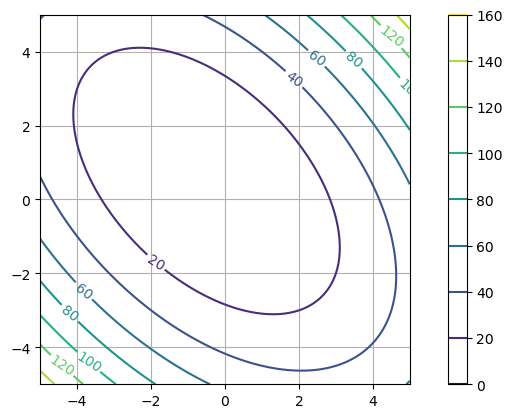

In [11]:
def contour():
    cs = plt.contour(X, Y, Z)
    axes = plt.gca()
    axes.clabel(cs)
    plt.colorbar()
    plt.axis("square")
    plt.grid(True)
contour()

In [12]:
def gradient_sequence(f, x0, n=100, lr=1e-3):
    x = x0
    xs = [x]
    ys = []
    for i in range(n-1):
        x = xs[-1]
        x.requires_grad = True
        y = f(x)
        y.backward()
        ys.append(y)
        g = x.grad
        x = x.detach()
        x = x - lr * g
        xs.append(x)
    y = f(x)
    ys.append(y)
    return torch.stack(xs).detach(), torch.tensor(ys)

    

In [13]:
xs, ys = gradient_sequence(f, x0=torch.tensor([3.0, 1.0]), n=10)
xs, ys

(tensor([[3.0000, 1.0000],
         [2.9850, 0.9910],
         [2.9701, 0.9821],
         [2.9552, 0.9732],
         [2.9405, 0.9644],
         [2.9258, 0.9557],
         [2.9112, 0.9470],
         [2.8966, 0.9384],
         [2.8822, 0.9298],
         [2.8678, 0.9213]]),
 tensor([29.0000, 28.6949, 28.3933, 28.0951, 27.8004, 27.5091, 27.2211, 26.9364,
         26.6550, 26.3768]))

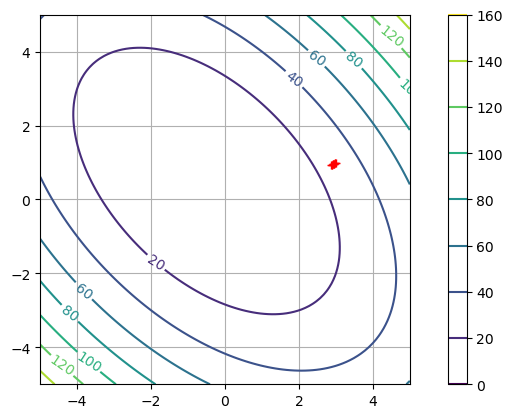

In [14]:
contour()
plt.plot(xs[:,0], xs[:,1], "r+--")
None

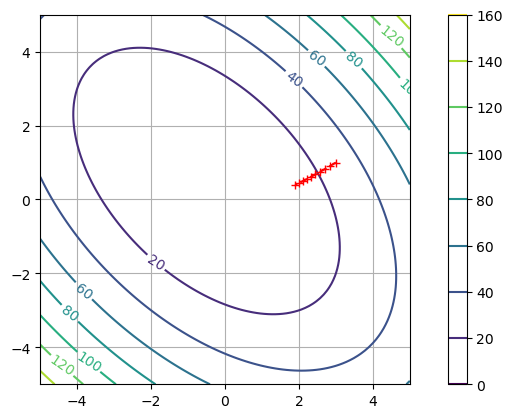

In [15]:
xs, ys = gradient_sequence(f, lr=1e-2, x0=torch.tensor([3.0, 1.0]), n=10)
contour()
plt.plot(xs[:,0], xs[:,1], "r+--")
None

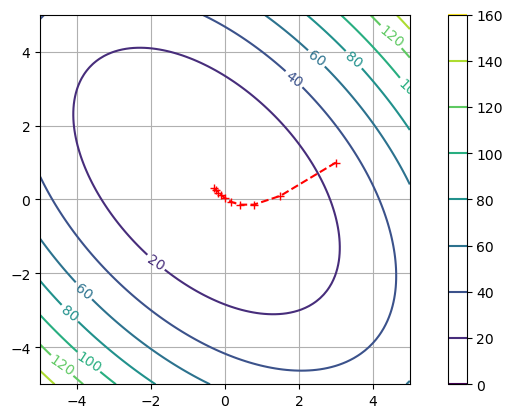

In [16]:
xs, ys = gradient_sequence(f, lr=1e-1, x0=torch.tensor([3.0, 1.0]), n=10)
contour()
plt.plot(xs[:,0], xs[:,1], "r+--")
None

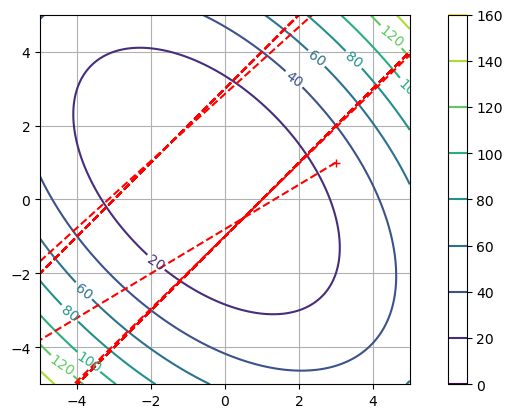

In [17]:
xs, ys = gradient_sequence(f, lr=1e-0, x0=torch.tensor([3.0, 1.0]), n=10)
contour()
plt.plot(xs[:,0], xs[:,1], "r+--")
None

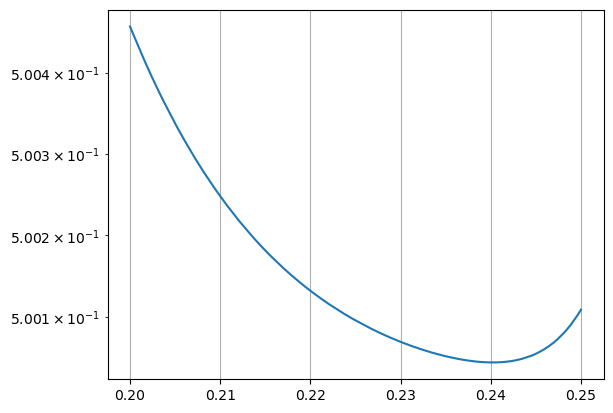

In [18]:
lrs = torch.linspace(0.2, 0.25, 1000)
yes = []
for lr in lrs:
    xs, ys = gradient_sequence(f, lr=lr, x0=torch.tensor([3.0, 1.0]), n=10)
    yes.append(ys[-1])
plt.plot(lrs, yes)
plt.yscale("log")
plt.grid(True)
None

In [19]:
i = torch.stack(yes).argmin().item()
i, lrs[i]

(802, tensor(0.2401))

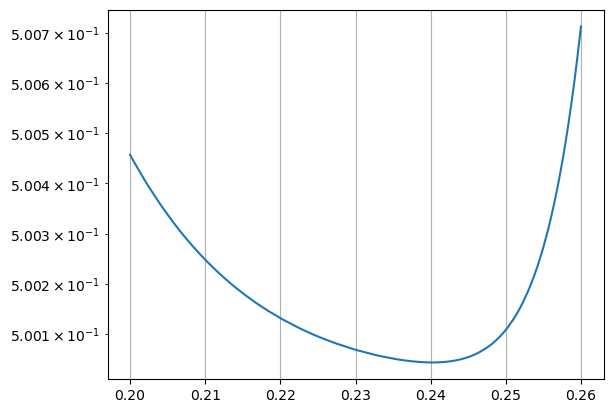

In [20]:
lrs = torch.linspace(0.200, 0.26, 1000)
yes = []
for lr in lrs:
    xs, ys = gradient_sequence(f, lr=lr, x0=torch.tensor([3.0, 1.0]), n=10)
    yes.append(ys[-1])
plt.plot(lrs, yes)
plt.yscale("log")
plt.grid(True)
None

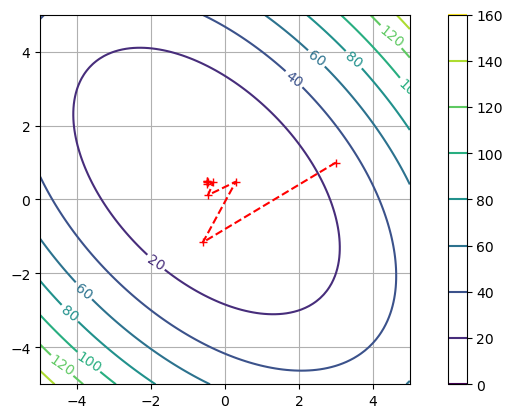

In [21]:
xs, ys = gradient_sequence(f, lr=0.24, x0=torch.tensor([3.0, 1.0]), n=10)
contour()
plt.plot(xs[:,0], xs[:,1], "r+--")
None

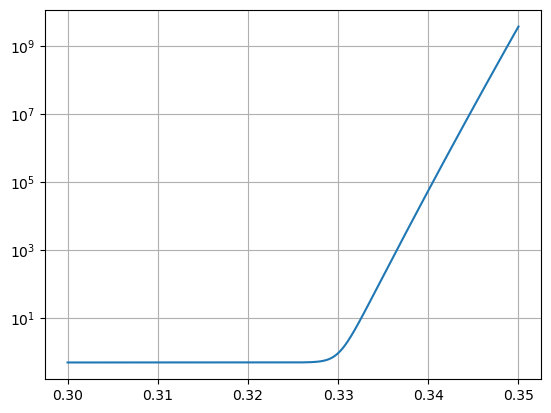

In [22]:
lrs = torch.linspace(0.3, 0.35, 1000)
yes = []
for lr in lrs:
    xs, ys = gradient_sequence(f, lr=lr, x0=torch.tensor([3.0, 1.0]), n=100)
    yes.append(ys[-1])
plt.plot(lrs, yes)
plt.yscale("log")
plt.grid(True)
None

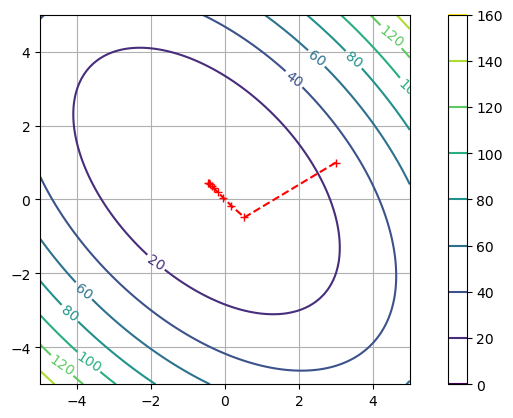

In [23]:
xs, ys = gradient_sequence(f, lr=0.33/2, x0=torch.tensor([3.0, 1.0]), n=10)
contour()
plt.plot(xs[:,0], xs[:,1], "r+--")
None

In [24]:
x = torch.tensor([3.0, 1.0], requires_grad=True) 
xs = [x.detach().clone()]
optimizer = torch.optim.SGD([x], lr=0.33/2)
n = 10
for i in range(n-1):
    y = f(x)
    y.backward()
    optimizer.step()
    xs.append(x.detach().clone())
    optimizer.zero_grad()
xs = torch.stack(xs)

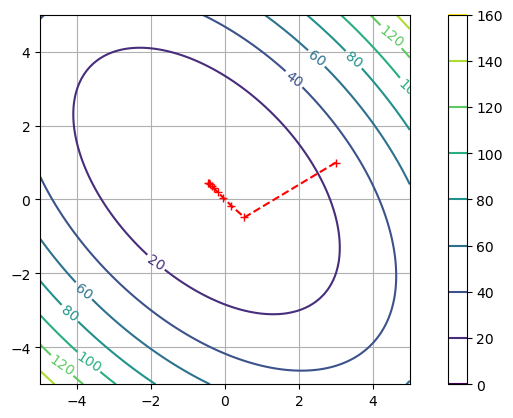

In [25]:
contour()
plt.plot(xs[:,0], xs[:,1], "r+--")
None

```{solution-end} ex1
```

### Theory

Let $n \in \mathbb{N}$, $A \in \mathbb{R}^{n \times n}$, $b \in \mathbb{R}^n$, $c \in \mathbb{R}^2$ and
$f :\mathbb{R}^n \to \mathbb{R}$ be the function defined by:

$$
f(x) := x^T A x + b^T x + c
$$

Then, for any $x \in \mathbb{R}^n$ and $dx \in \mathbb{R}^n$, we have

$$
\begin{split}
df(x) (dx) &= x^T A dx + dx^T A x + b^T dx \\
           &= x^T A dx + x^T A^T dx + b^T dx \\
           &= (x^T A + x^T A^T + b^T) dx \\
           &= (A^Tx + Ax + b)^T dx
\end{split}
$$
Hence,
$$
\nabla f(x) = (A + A^T)x + b = 2 S x + b
$$
where 
$$
S:= \frac{1}{2}(A + A^T)
$$ 
is **symmetric**: $S^T = S$. When it is **definite** positive, that is

$$
\forall \, x \in \mathbb{R}^n, \; x^T S x \geq 0 
\;
\mbox{ and }
\;
x^T S x  = 0 \,\Rightarrow \, x = 0
$$

then the function $f(x)$ has a unique (global) minimum $x_*$, solution of $\nabla f(x_*) = 0$, i.e.

$$
x_* = - (A + A^T)^{-1} b = - \frac{1}{2} S^{-1} b.
$$

```{note}
Note that 
$$
f(x) = \frac{1}{2} x^T A x + \frac{1}{2} x^T A^T x + b^T x + c = \frac{1}{2} x^T \left(A + A^T \right) x + b^T x + c
= x^T S x + b^Tx + c
$$
so we may always enforce the constraint that $A$ is symmetric when we define $f$.
```

```{note}
Note that $S$ is positive definite if and only if $f$ is **strictly proper**, i.e.
$$
f(x) \to +\infty \, \mbox{ when } \|x\| \to + \infty.
$$
```


```{note}
Since $\nabla f(x) = (A + A^T)x + b = 2 S x + b$, the hessian matrix satisfies:
$$
H := \nabla^2 f(x) = (A+ A^T) = 2S.
$$
```

and 

$$
f(x_*) = x_*^T S x_* + \frac{1}{2} b^T x_* + c = -\frac{1}{4} b^T S^{-1} b + c 
$$

$$
x_{n+1} = x_n - \eta \nabla f(x_n) = x_n - \eta (2S x_n + b) = (I - 2 \eta S) x_n -\eta b
$$

$$
e_n := x_{n} - x_*
$$

$$
\begin{split}
e_{n+1} - x_*  &= e_{n+1} + \frac{1}{2} S^{-1} b \\
               &= (I - 2 \eta S) x_n -\eta b + \frac{1}{2} S^{-1} b \\
               &= (I - 2 \eta S) (x_n +  \frac{1}{2} S^{-1} b) +\eta b -\eta b \\
               &= (I - 2 \eta S) e_n
\end{split}
$$

The matrix $S$ is real, symmetric and positive definite. Hence, there is an orthogonal matrix $P$ ($P^{-1} = P^T$)
and $0 < \lambda_1 \leq \dots \leq \lambda_n$ such that.
$$
S = P^T \mathrm{diag}(\lambda_1, \dots, \lambda_n)P.
$$
The **condition number** of $S$ is
$$
\kappa := \frac{\lambda_n}{\lambda_1} \geq 1.
$$

The matrix $M := 1 - 2 \eta S$ is also symmetric and
$$
M = P^T \mathrm{diag}(1 - 2 \eta \lambda_1, \dots, 1 - 2 \eta \lambda_n) P
$$

Since $e_n = P^T M^n P e_0$, the error will converge to $0$ for any $e_0$ iff every coefficient $1 - 2 \eta_i$ is in 
$\left]-1, 1\right[$, which holds iff $-1 < 1 - 2 \eta \lambda_n$, i.e.
$$
\eta < \frac{1}{\lambda_n}.
$$

Now, if we pick for example 
$$
\eta  = \frac{1}{2\lambda_n}, 
$$
we get
$$
M = P^T \mathrm{diag}(1 -  \lambda_1/\lambda_n, 1 - \lambda_2/\lambda_n\dots, 0) P
$$
and thus
$$
\|e_{n+1}\| \leq \left(1 - \frac{1}{\kappa}\right) \|e_n\|  
$$
and therefore
$$
\|e_n\| \leq \left(1 - \frac{1}{\kappa} \right)^n \|e_0\|.
$$

```{note}
The "best" choice, that leads to the fastest convergence is
$$
\eta =\frac{1}{\lambda_1 + \lambda_n}
$$
which provides
$$
\|e_n\| \leq \left(1 - \frac{1+1}{\kappa+1} \right)^n \|e_0\|.
$$
```

Now, some simple computations provide $f(x) - f(x_*) = e^T S e$, thus
$$
f(x_{n+1}) - f(x_*) = e_{n+1}^T S e_{n+1} = e_n^T (I - 2\eta S) S (I - 2\eta S) e_n = e_n^T (I - 2\eta S)^2 S e_n
$$
and by induction
$$
f(x_n) - f(x_*) = e_0^T (I - 2 \eta S)^{2n}S e_0.
$$

Now for $\eta = 1/(2\lambda_n)$, for example, we get
$$
\|I - 2 \eta S)\| \leq 1 -\frac{1}{\kappa}
$$
$$
\|S\| \leq \lambda_n
$$
and thus
$$
\|f(x_n) - f(x_*)\| \leq \left(1-\frac{1}{\kappa}\right)^n \lambda_n \|e_0\|^2
$$


In [26]:
x0_m = 1.0
x1_m = 2.0
m = torch.tensor(10.0)
theta = torch.tensor(torch.pi/4)
R = torch.tensor([
    [torch.cos(theta), -torch.sin(theta)], 
    [torch.sin(theta), torch.cos(theta)]]
)
S = R @ torch.diag(torch.tensor([1.0, 2.0])) @ R.T
s_00 = S[0, 0].item()
s_01 = S[0, 1].item()
s_11 = S[1, 1].item()

In [27]:
def f(x0, x1): # no need to support anything but scalars (numbers & 0-dim tensors) here
    dx0 = x0 - x0_m
    dx1 = x1 - x1_m
    return 0.5 * (s_00 * dx0 * dx0 + 2.0 * s_01 * dx0 * dx1 + s_11 * dx1 * dx1) + m

In [28]:
x = torch.linspace(0.0, 5.0, 100)
y = torch.linspace(0.0, 5.0, 100)
X, Y = torch.meshgrid(x, y, indexing="xy")
X, Y

(tensor([[0.0000, 0.0505, 0.1010,  ..., 4.8990, 4.9495, 5.0000],
         [0.0000, 0.0505, 0.1010,  ..., 4.8990, 4.9495, 5.0000],
         [0.0000, 0.0505, 0.1010,  ..., 4.8990, 4.9495, 5.0000],
         ...,
         [0.0000, 0.0505, 0.1010,  ..., 4.8990, 4.9495, 5.0000],
         [0.0000, 0.0505, 0.1010,  ..., 4.8990, 4.9495, 5.0000],
         [0.0000, 0.0505, 0.1010,  ..., 4.8990, 4.9495, 5.0000]]),
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0505, 0.0505, 0.0505,  ..., 0.0505, 0.0505, 0.0505],
         [0.1010, 0.1010, 0.1010,  ..., 0.1010, 0.1010, 0.1010],
         ...,
         [4.8990, 4.8990, 4.8990,  ..., 4.8990, 4.8990, 4.8990],
         [4.9495, 4.9495, 4.9495,  ..., 4.9495, 4.9495, 4.9495],
         [5.0000, 5.0000, 5.0000,  ..., 5.0000, 5.0000, 5.0000]]))

In [29]:
fvmap = torch.vmap(f)
Zf = fvmap(X.flatten(), Y.flatten())
Z = Zf.reshape(X.shape)
Z

tensor([[12.7500, 12.7267, 12.7071,  ..., 28.3006, 28.6484, 29.0000],
        [12.6257, 12.6010, 12.5802,  ..., 28.0525, 28.3990, 28.7494],
        [12.5051, 12.4792, 12.4572,  ..., 27.8083, 28.1535, 28.5026],
        ...,
        [18.5026, 18.3555, 18.2123,  ..., 22.0531, 22.2772, 22.5051],
        [18.7494, 18.6011, 18.4566,  ..., 22.1762, 22.3990, 22.6256],
        [19.0000, 18.8504, 18.7046,  ..., 22.3031, 22.5246, 22.7500]])

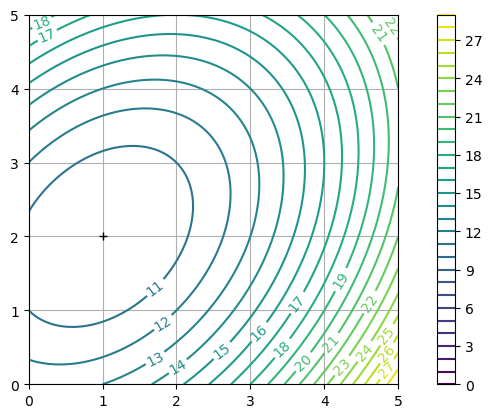

In [30]:
cs = plt.contour(X, Y, Z, levels=range(0, 30))
axes = plt.gca()
axes.clabel(cs)
plt.plot([x0_m], [x1_m], "k+")
plt.colorbar()
plt.axis("square")
plt.grid(True)
None

## Brute-force (0-order method)

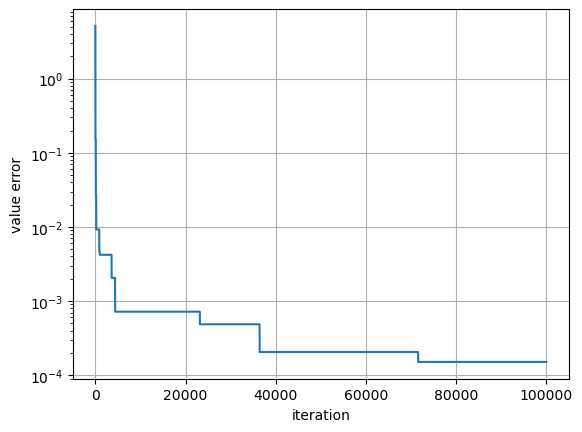

In [31]:
N = 100_000
xs, ys = 5.0 * torch.rand(N), 5.0 * torch.rand(N)
fs = [f(x, y) for x, y in zip(xs, ys)]
x, y = None, None
fxy = torch.inf
es = []
xys = []
for i in range(N):
    if fs[i] < fxy:
        fxy = fs[i]
        x, y = xs[i], ys[i]
    es.append(fxy - m )
    xys.append((x, y))
plt.plot(es)
plt.gca().set_yscale('log')
plt.grid(True)
plt.xlabel("iteration")
plt.ylabel("value error")
None

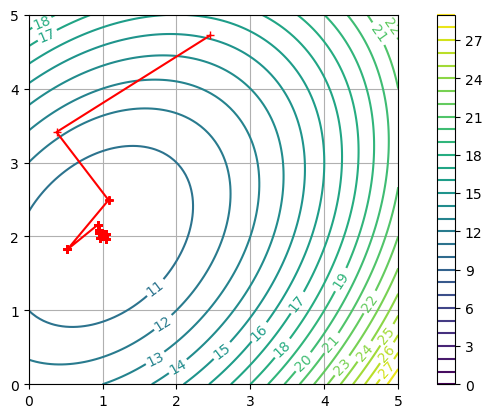

In [32]:
cs = plt.contour(X, Y, Z, levels=range(0, 30))
axes = plt.gca()
axes.clabel(cs)
plt.plot([x0_m], [x1_m], "k+")
plt.colorbar()
plt.axis("square")
plt.grid(True)
xs = [x for x, _ in xys]
ys = [y for _, y in xys]
plt.plot(xs, ys, "r+-")
None

## Basic Gradient

In [33]:
grad_f = torch.func.grad(f, (0, 1))
grad_f(torch.tensor(1.0), torch.tensor(4.0))

(tensor(-1.0000), tensor(3.0000))

In [34]:
N = 100
lr = 0.1
xs, ys = [], []
x = 4.0
y = 1.0
for i in range(N):
    grad_fxy = grad_f(torch.tensor(x), torch.tensor(y))
    dx = grad_fxy[0].item()
    dy = grad_fxy[1].item()
    x = x - lr * dx
    y = y - lr * dy
    xs.append(x)
    ys.append(y)
es = [f(x, y) - m for x, y in zip(xs, ys)]

In [35]:
def min_grad(f, lr, N=100):
    xs, ys = [], []
    x = 4.0
    y = 1.0
    for i in range(N):
        grad_fxy = grad_f(torch.tensor(x), torch.tensor(y))
        dx = grad_fxy[0].item()
        dy = grad_fxy[1].item()
        x = x - lr * dx
        y = y - lr * dy
        xs.append(x)
        ys.append(y)
    es = [f(x, y) - m for x, y in zip(xs, ys)]
    return xs, ys, es

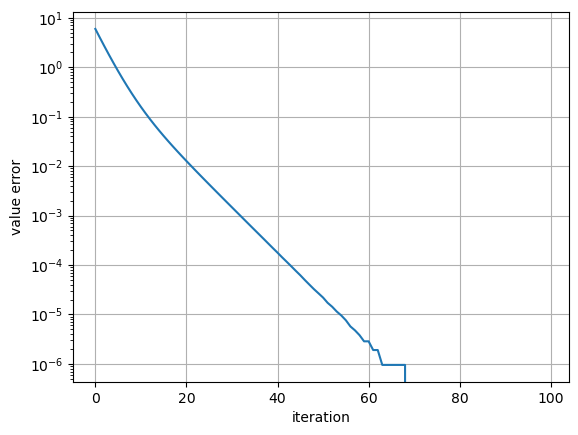

In [36]:
plt.plot(es)
plt.gca().set_yscale('log')
plt.grid(True)
plt.xlabel("iteration")
plt.ylabel("value error")
None

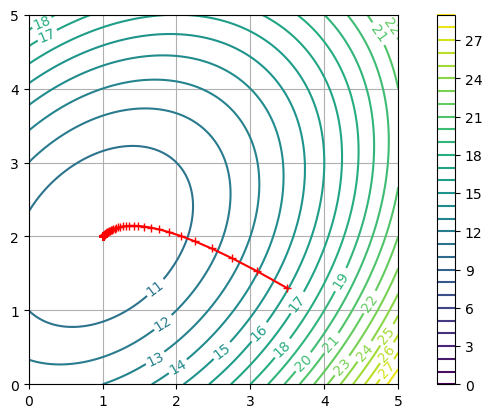

In [37]:
cs = plt.contour(X, Y, Z, levels=range(0, 30))
axes = plt.gca()
axes.clabel(cs)
plt.plot([x0_m], [x1_m], "k+")
plt.colorbar()
plt.axis("square")
plt.grid(True)
plt.plot(xs, ys, "r+-")
None

In [38]:
xs, ys, es = min_grad(f, lr=0.1, N=100)

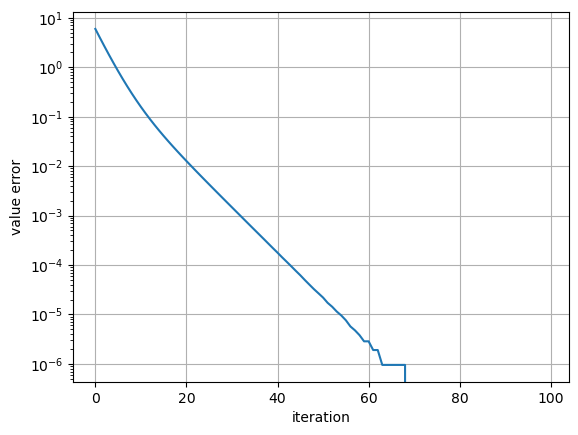

In [39]:
plt.plot(es)
plt.gca().set_yscale('log')
plt.grid(True)
plt.xlabel("iteration")
plt.ylabel("value error")
None


## Old Stuff

In [40]:
x_0 = 2.0
y_0 = 1.0

def f(x, y): # make sure that f can handle tensor arguments of arbitrary size
    delta_0 = x - x_0
    delta_1 = y - y_0
    return delta_0**2 + delta_1**2 + delta_0 * delta_1

def grad_f(x, y): # debug
    with torch.no_grad():
        delta_0 = x - x_0
        delta_1 = y - y_0
        return (2 * delta_0 + delta_1, 2 * delta_1 + delta_0)

In [41]:
f(0, 0)

7.0

In [42]:
f(2, 1)

0.0

In [43]:
x = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
y = torch.tensor([[-1.0, 0.0], [1.0, 2.0]])
f(x, y)

tensor([[7., 1.],
        [1., 7.]])

In [44]:
x = torch.linspace(0.0, 4.0, 100)
y = torch.linspace(-1.0, 3.0, 100)
X, Y = torch.meshgrid(x, y, indexing="ij")
Z = f(X, Y)

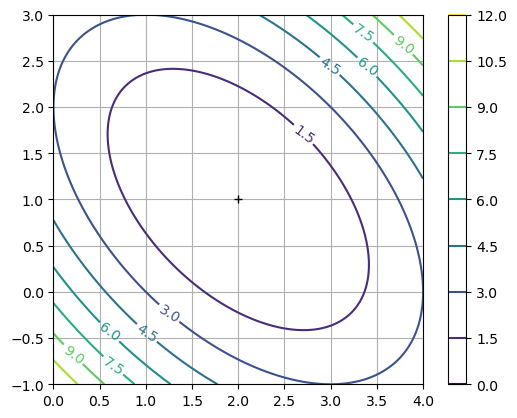

In [45]:
def contour():
    cs = plt.contour(X, Y, Z)
    plt.plot(2.0, 1.0, "k+")
    axes = plt.gca()
    axes.clabel(cs)
    plt.colorbar()
    plt.grid(True)
    axes.set_aspect(1.0)
contour()

In [46]:
x = torch.tensor(1.0)
y = x*x + 1
print(x, y, x.grad)
# y.backward() # won't work: RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn. OK!

tensor(1.) tensor(2.) None


In [47]:
x = torch.tensor(1.0, requires_grad=True)
y = x*x  + 1
print(x, y, x.grad)
y.backward()
print(x, y, x.grad)
x.grad += 1.0
print(x.grad)

tensor(1., requires_grad=True) tensor(2., grad_fn=<AddBackward0>) None
tensor(1., requires_grad=True) tensor(2., grad_fn=<AddBackward0>) tensor(2.)
tensor(3.)


In [48]:
def manual_gradient(x0=0.0, y0=0.0, lr=0.1, n=10):
    x = torch.tensor(x0, requires_grad=True)
    x.grad = torch.tensor(0.0)
    y = torch.tensor(0.0, requires_grad=True)
    y.grad = torch.tensor(y0)
    
    xs, ys, zs = [], [], []
    for i in range(n):
        x.grad = torch.tensor(0.0)
        y.grad = torch.tensor(0.0)
        z = f(x, y)
        z.backward()
        
        xs.append(x.item())
        ys.append(y.item())
        zs.append(z.item())

        x.requires_grad = False
        y.requires_grad = False
        x -= lr * x.grad # RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.
        y -= lr * y.grad # with torch.no_grad() (or equivalent) is required
        x.requires_grad = True
        y.requires_grad = True
    return xs, ys, zs

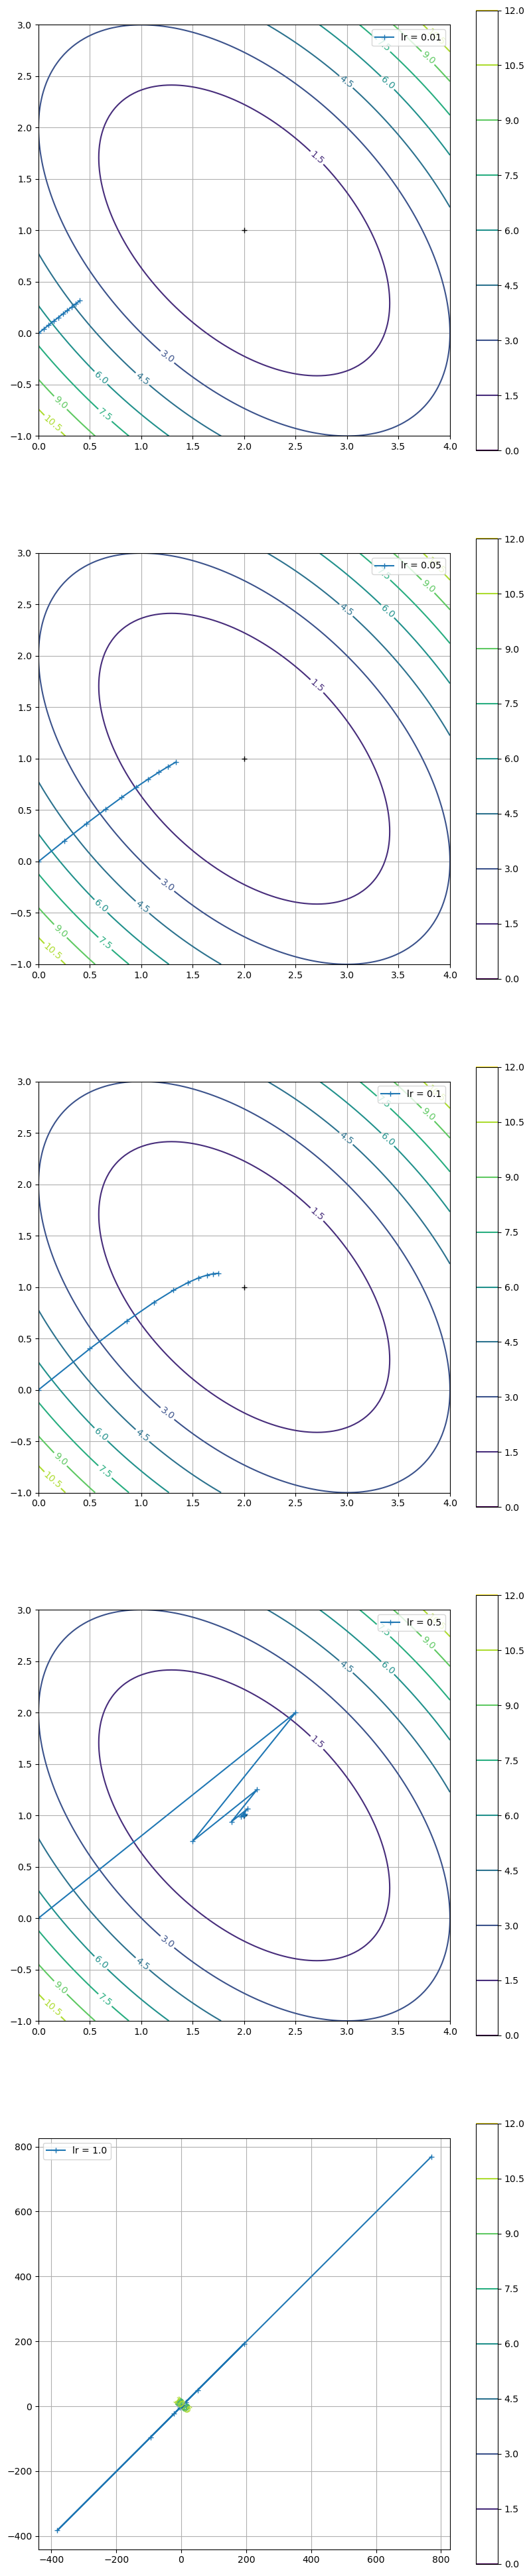

In [49]:
lrs = [0.01, 0.05, 0.1, 0.5, 1.0]
n = 100
fig, axes = plt.subplots(len(lrs))
fig.set_figheight(len(lrs)*10)
fig.set_figwidth(10)
for ax, lr in zip(axes, lrs):
    plt.sca(ax)
    contour()
    xs, ys, _ = manual_gradient(lr=lr, n=10)
    plt.plot(xs, ys, "-+", label="lr = " +str(lr))
    plt.legend()

In [50]:
def min_SGD(x0=0.0, y0=0.0, n=10, **options):
    x = torch.tensor(x0, requires_grad=True)
    x.grad = torch.tensor(0.0)
    y = torch.tensor(0.0, requires_grad=True)
    y.grad = torch.tensor(y0)
    optimizer = torch.optim.SGD([x, y], **options)
    
    xs, ys, zs = [], [], []
    for i in range(n):
        z = f(x, y)
        xs.append(x.item())
        ys.append(y.item())
        zs.append(z.item())
        x.grad.zero_()
        y.grad.zero_()
        z.backward(); optimizer.step()
    return xs, ys, zs

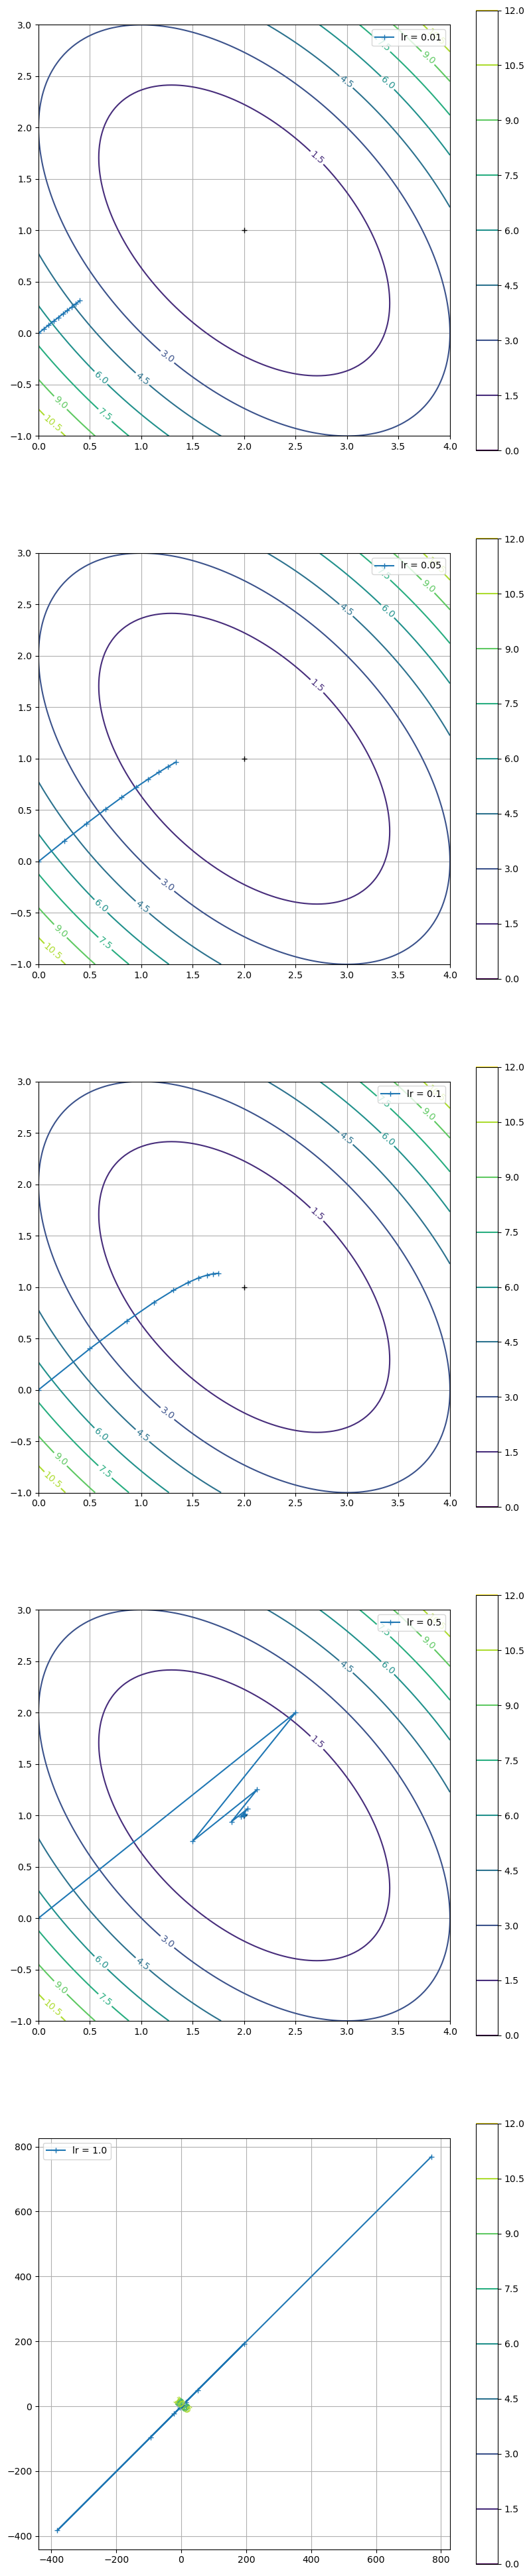

In [51]:
lrs = [0.01, 0.05, 0.1, 0.5, 1.0]
n = 10
fig, axes = plt.subplots(len(lrs))
fig.set_figheight(len(lrs)*10)
fig.set_figwidth(10)
for ax, lr in zip(axes, lrs):
    plt.sca(ax)
    contour()
    xs, ys, _ = min_SGD(n=n, lr=lr)
    plt.plot(xs, ys, "-+", label="lr = " +str(lr))
    plt.legend()

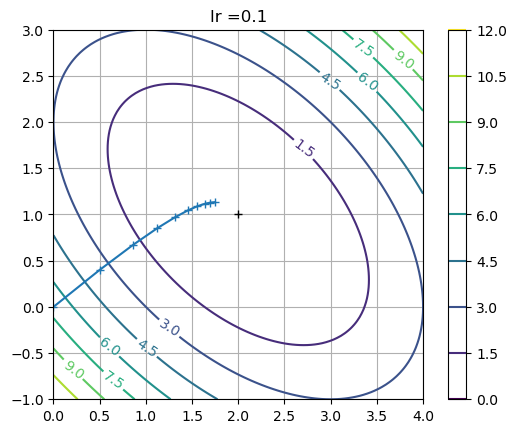

In [52]:
lr = 0.1
n = 10

contour()
xs, ys, _ = min_SGD(n=n, lr=lr)
plt.plot(xs, ys, "-+")
plt.title(f"{lr =}")
None

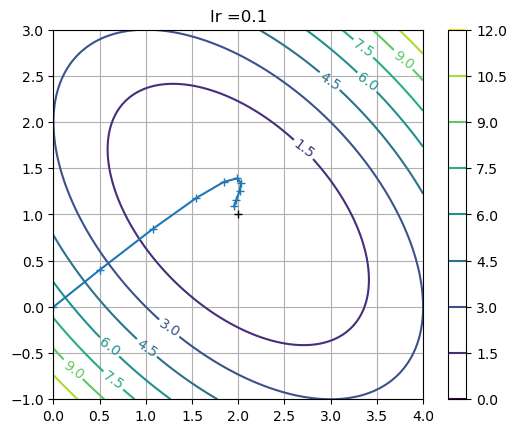

In [53]:
n = 10

contour()
xs, ys, _ = min_SGD(n=n, lr=0.1, momentum=0.5, dampening=0.1)
plt.plot(xs, ys, "-+")
plt.title(f"{lr =}")
None

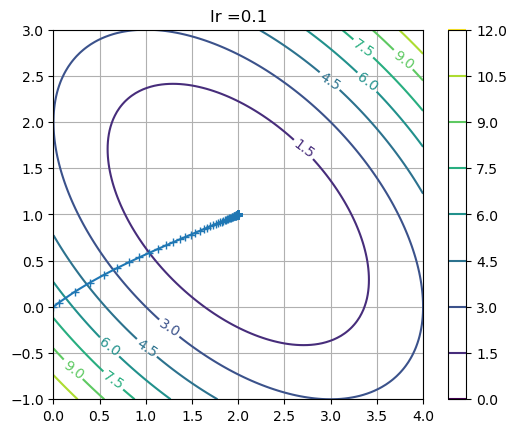

In [54]:
def min_LBFGS(x0=0.0, y0=0.0, n=10, **options):
    x = torch.tensor(x0, requires_grad=True)
    x.grad = torch.tensor(0.0)
    y = torch.tensor(0.0, requires_grad=True)
    y.grad = torch.tensor(y0)
    optimizer = torch.optim.LBFGS([x, y], **options)

    xs, ys, zs = [], [], []
    
    for i in range(n):
        def closure():
            z = f(x, y)
            xs.append(x.item())
            ys.append(y.item())
            zs.append(z.item())
            x.grad.zero_()
            y.grad.zero_()
            z.backward()
            return z
        optimizer.step(closure)
    return xs, ys, zs

n = 10

contour()
xs, ys, _ = min_LBFGS(n=n, lr=0.1)
plt.plot(xs, ys, "-+")
plt.title(f"{lr =}")
None

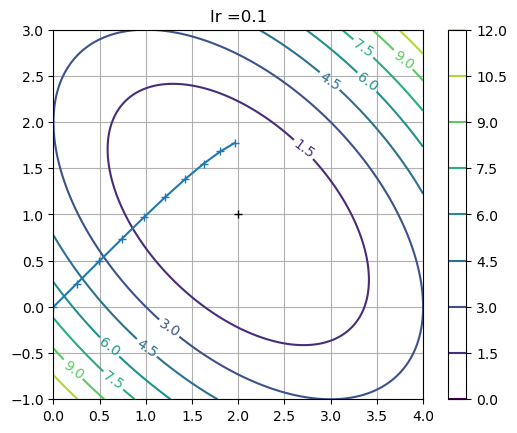

In [55]:
def min_Adam(x0=0.0, y0=0.0, n=10, **options):
    x = torch.tensor(x0, requires_grad=True)
    x.grad = torch.tensor(0.0)
    y = torch.tensor(0.0, requires_grad=True)
    y.grad = torch.tensor(y0)
    optimizer = torch.optim.Adam([x, y], **options)

    xs, ys, zs = [], [], []
    
    for i in range(n):
        def closure():
            z = f(x, y)
            xs.append(x.item())
            ys.append(y.item())
            zs.append(z.item())
            x.grad.zero_()
            y.grad.zero_()
            z.backward()
            return z
        optimizer.step(closure)
    return xs, ys, zs

n = 10

contour()
xs, ys, _ = min_Adam(n=n, lr=0.25)
plt.plot(xs, ys, "-+")
plt.title(f"{lr =}")
None

### Higher dimensions

In [56]:
d = 10
Sigma = torch.normal(torch.zeros(d, d), torch.ones(d, d))

In [57]:
A = Sigma.T @ Sigma
A

tensor([[11.0310, -1.3068, -0.6901, -2.4987, -2.8374, -5.1753,  2.0515, -5.8089,
          2.6590,  4.5011],
        [-1.3068,  6.5203, -3.7554,  0.5813,  5.2461, -2.7646,  5.0145, -1.8397,
         -0.7339, -3.8888],
        [-0.6901, -3.7554,  9.9277, -0.8757, -2.6043,  1.4959,  1.6817, -0.5775,
         -1.0303,  3.2072],
        [-2.4987,  0.5813, -0.8757,  7.6140,  0.8952,  1.9463, -5.8867,  1.2095,
          2.6459, -3.2768],
        [-2.8374,  5.2461, -2.6043,  0.8952, 16.7794, -0.8483,  5.8260,  0.1211,
          1.9863, -0.5707],
        [-5.1753, -2.7646,  1.4959,  1.9463, -0.8483, 16.4474, -3.9631,  0.7150,
          1.7319,  1.0857],
        [ 2.0515,  5.0145,  1.6817, -5.8867,  5.8260, -3.9631, 13.9858, -5.3643,
         -3.0580,  2.4271],
        [-5.8089, -1.8397, -0.5775,  1.2095,  0.1211,  0.7150, -5.3643,  7.1654,
         -1.9541, -2.7827],
        [ 2.6590, -0.7339, -1.0303,  2.6459,  1.9863,  1.7319, -3.0580, -1.9541,
          5.2893,  1.0053],
        [ 4.5011, -

In [58]:
U, S, V = torch.svd(A)
S

tensor([28.9167, 23.7107, 16.8603, 13.8080,  8.8992,  6.8306,  1.6505,  1.0155,
         0.2587,  0.1065])

In [59]:
lambda_1 = S[-1].item()
lambda_1

0.10648704320192337

In [60]:
lambda_d = S[0].item()
lambda_d

28.91674041748047

In [61]:
kappa = lambda_d / lambda_1
kappa

271.55172636963755

In [62]:
def f(x):
    return (x @ A @ x).squeeze()

In [63]:
lr = 1e-3
x = torch.normal(torch.zeros(d), torch.ones(d))
x.requires_grad=True
ys = [f(x).item()]
print(ys[-1])
optimizer = torch.optim.SGD([x], lr=lr)

57.99327087402344


In [64]:
n = 10_000
for i in range(n):
    y = f(x)
    y.backward()
    ys.append(y.item())
    optimizer.step()
    optimizer.zero_grad()

Text(0, 0.5, 'Objective value')

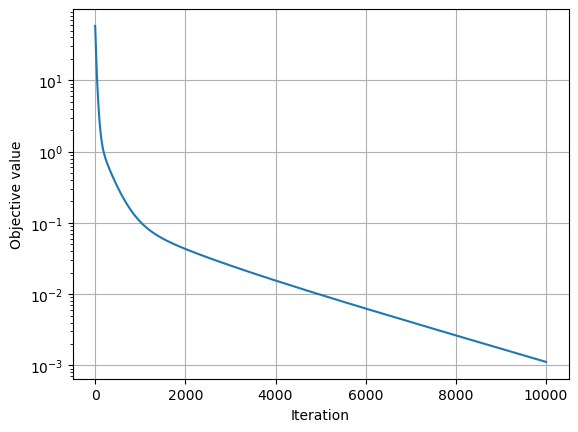

In [65]:
plt.plot(ys)
plt.yscale("log")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Objective value")

In [66]:
lr = 0.5 / lambda_d
x = torch.normal(torch.zeros(d), torch.ones(d))
x.requires_grad=True
ys = [f(x).item()]
print(ys[-1])
optimizer = torch.optim.SGD([x], lr=lr)

23.43024253845215


In [67]:
n = 10_000
for i in range(n):
    y = f(x)
    y.backward()
    ys.append(y.item())
    optimizer.step()
    optimizer.zero_grad()

Text(0, 0.5, 'Objective value')

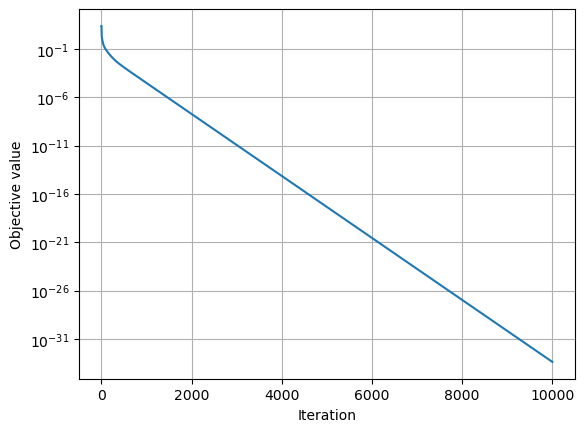

In [68]:
plt.plot(ys)
plt.yscale("log")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Objective value")

In [69]:
lr = 1.0 / (lambda_d + lambda_1)
x = torch.normal(torch.zeros(d), torch.ones(d))
x.requires_grad=True
ys = [f(x).item()]
print(ys[-1])
optimizer = torch.optim.SGD([x], lr=lr)

105.8412857055664


In [70]:
n = 10_000
for i in range(n):
    y = f(x)
    y.backward()
    ys.append(y.item())
    optimizer.step()
    optimizer.zero_grad()

Text(0, 0.5, 'Objective value')

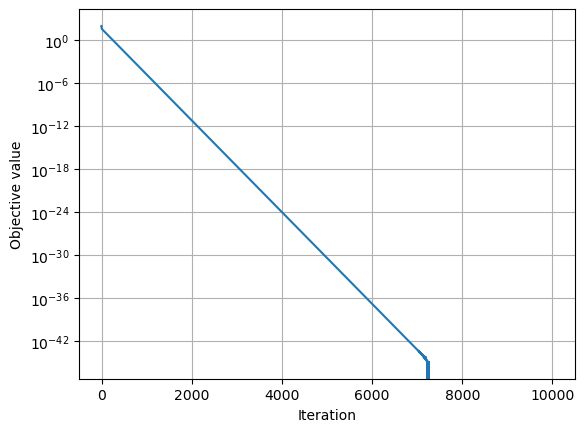

In [71]:
plt.plot(ys)
plt.yscale("log")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Objective value")

In [72]:
lr = 0.99 / lambda_d
x = torch.normal(torch.zeros(d), torch.ones(d))
x.requires_grad=True
ys = [f(x).item()]
print(ys[-1])
optimizer = torch.optim.SGD([x], lr=lr)

68.83966064453125


In [73]:
n = 10_000
for i in range(n):
    y = f(x)
    y.backward()
    ys.append(y.item())
    optimizer.step()
    optimizer.zero_grad()

Text(0, 0.5, 'Objective value')

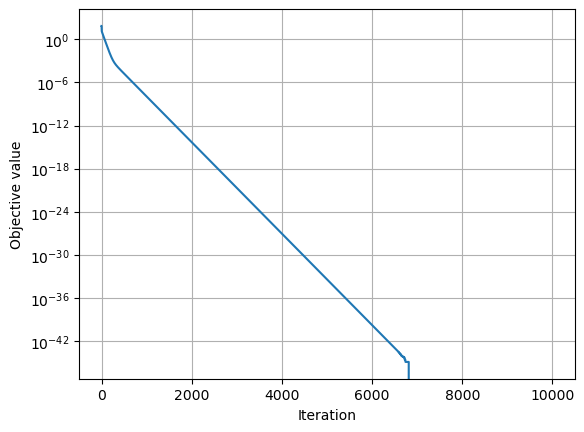

In [74]:
plt.plot(ys)
plt.yscale("log")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Objective value")

In [75]:
lr = 1.01 / lambda_d
x = torch.normal(torch.zeros(d), torch.ones(d))
x.requires_grad=True
ys = [f(x).item()]
print(ys[-1])
optimizer = torch.optim.SGD([x], lr=lr)

165.88397216796875


In [76]:
n = 10_000
for i in range(n):
    y = f(x)
    y.backward()
    ys.append(y.item())
    optimizer.step()
    optimizer.zero_grad()

Text(0, 0.5, 'Objective value')

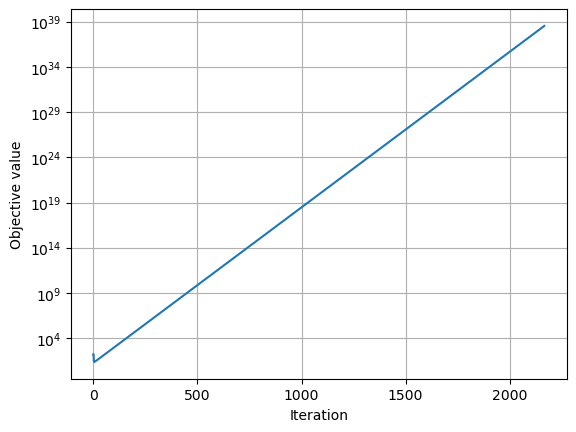

In [77]:
plt.plot(ys)
plt.yscale("log")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Objective value")